In [55]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [56]:
import tensorflow as tf

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from GRU_stock_data_processing import *
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

sns.set()
tf.random.set_seed(1234)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Dataset and Select Ticker

In [58]:
stock_df = pd.read_csv("../stock_yfinance_data.csv")
ticker = 'TSLA'
stock_filt = stock_df['Stock Name'] == ticker
df = stock_df[stock_filt]
window = 30
df = clean_stock_data(df, window)
df.head()

,date,open,high,low,close,adj_close,volume,stock_name,moving_max,moving_min,moving_avg_volume,moving_avg_HL
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA,258.493347,258.493347,53868000.0,4.709991
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA,258.493347,258.406677,52481100.0,5.220001
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA,260.510010,258.406677,65470700.0,6.907776
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA,260.510010,258.406677,62927475.0,7.106659
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA,260.916656,258.406677,59121660.0,6.581329


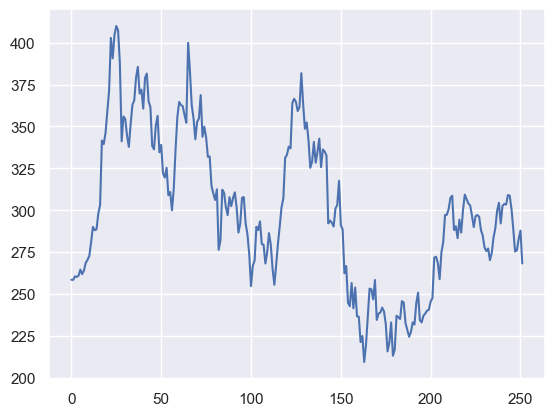

In [59]:
plt.plot(df['close'].values)

### Generate Useful Features

In [60]:
features = gen_features(df)
#only keep window-end samples before full window are invalid
features = features[window:]
features.head()

,target,close,volume,day_HL,sma,ema,rsi,macd_line,macd_signal,macd_histogram,bb_middle,bb_upper,bb_lower
30,-0.415753,1.389737,-0.225144,1.205485,1.225250,1.240823,1.294347,0.337084,0.377391,-0.040307,1.225250,2.329673,0.120826
31,-2.829310,1.274551,-0.123877,0.834094,1.271798,1.244036,1.048356,0.298930,0.361699,-0.062768,1.271798,2.295270,0.248325
32,-1.938224,1.195642,0.185585,1.239311,1.307861,1.239427,1.022191,0.259337,0.341226,-0.081890,1.307861,2.261470,0.354252
33,4.079377,1.361721,-0.103368,1.246601,1.353595,1.251074,1.061015,0.238609,0.320703,-0.082094,1.353595,2.216830,0.490360
34,3.250121,1.494039,0.042524,1.399640,1.405584,1.274213,1.051915,0.230206,0.302603,-0.072398,1.405584,2.159023,0.652145


Text(0.5, 1.0, 'Normalized Closing Price Using Accumulated % Changes')

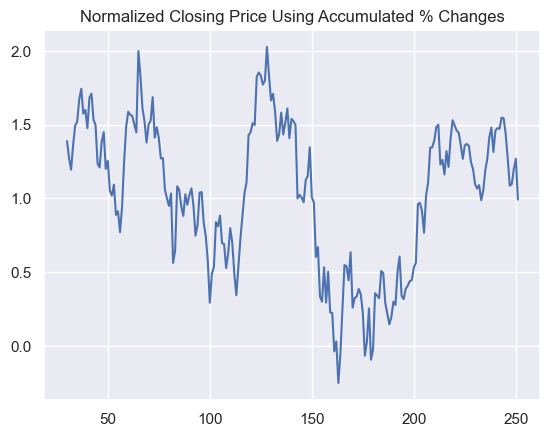

In [61]:
plt.plot(features['close'])
plt.title('Normalized Closing Price Using Accumulated % Changes')

### Generate GRU train and test split

In [62]:
target = 0 #predict closing delta
data = features.to_numpy()
datax, datay = generate_LSTM_data(data, sequence_size=20, target_idx=target, pred_size=2)
print('LSTM Data')
print("> Data X: " + str(datax.shape))
print("> Data y: " + str(datay.shape))
test_size = 30
datax_train = datax[:-test_size]
datay_train = datay[:-test_size]
print('Train Set')
print("> Data X: " + str(datax_train.shape))
print("> Data y: " + str(datay_train.shape))
datax_test = datax[-test_size:]
datay_test = datay[-test_size:]
print('Test Set')
print("> Data X: " + str(datax_test.shape))
print("> Data y: " + str(datay_test.shape))

LSTM Data
> Data X: (200, 20, 13)
> Data y: (200, 2)
Train Set
> Data X: (170, 20, 13)
> Data y: (170, 2)
Test Set
> Data X: (30, 20, 13)
> Data y: (30, 2)


### Define Model

In [63]:
class GRU_Model(tf.keras.Model):
    def __init__(self, num_layers, hidden_dim, output_size, dropout_rate=0.1):
        super(GRU_Model, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.output_size = output_size

        self.gru_layers = [
            tf.keras.layers.GRU(
                hidden_dim,
                activation='tanh',
                return_sequences=True
            ) for _ in range(num_layers-1)
        ]
        self.last_gru = tf.keras.layers.GRU(
            hidden_dim,
            activation='tanh',
            return_sequences=False
        )
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense1 = tf.keras.layers.Dense(hidden_dim//2)
        self.dense2 = tf.keras.layers.Dense(output_size)
    
    def call(self, x):
        for gru_layer in self.gru_layers:
            x = gru_layer(x)
            x = self.dropout(x)
        x = self.last_gru(x)
        x = self.dropout(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return x

### Train Model

In [64]:
mymodel = GRU_Model(num_layers=5, hidden_dim=128, output_size=2, dropout_rate=0.1)
mymodel.compile(optimizer="adam", loss="mean_squared_error")
eval = mymodel.evaluate(datax_train, datay_train)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 18.9452  


In [65]:
history = mymodel.fit(
    x = datax_train,
    y = datay_train,
    validation_split=0.25,
    epochs=20,
    batch_size=128
)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 19.9209 - val_loss: 15.8636
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 19.9091 - val_loss: 15.4770
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 19.7810 - val_loss: 15.2127
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 19.7794 - val_loss: 15.2193
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 19.7421 - val_loss: 15.3637
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 19.6766 - val_loss: 15.4097
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 19.6219 - val_loss: 15.1803
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 19.5524 - val_loss: 14.8810
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 19.4643 - val_loss: 14.7329
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 19.3142 - val_loss: 14.5362
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 19.1432 - val_loss: 14.1534
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 18.9353

### Plot Performance

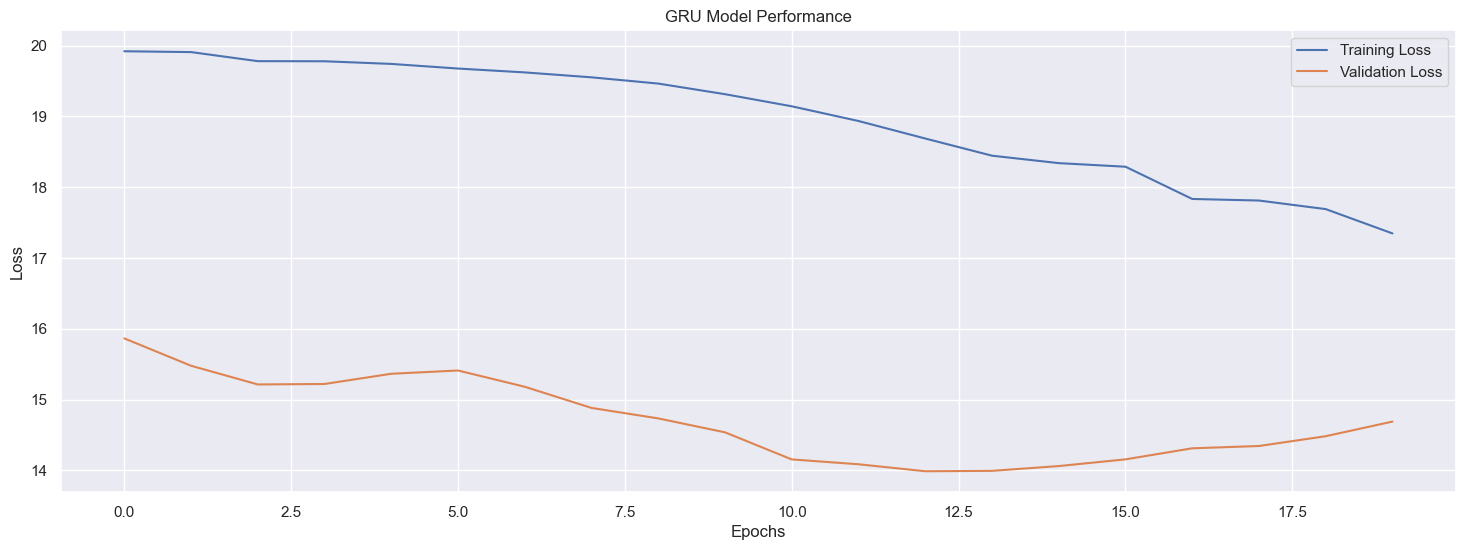

In [66]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("GRU Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 1 Day Advance Prediction

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


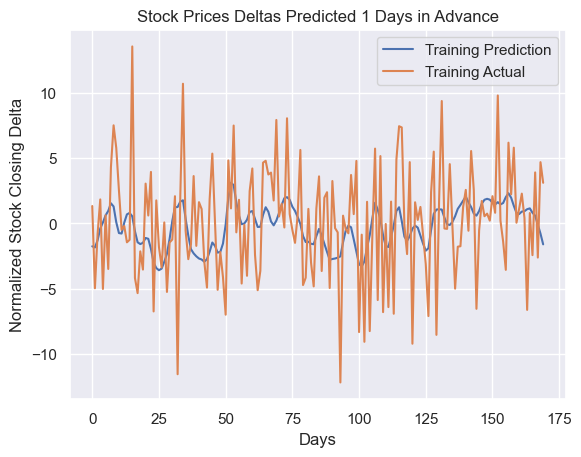

In [67]:
train_predictions = mymodel.predict(datax_train)
train_actual = datay_train
plt.plot(train_predictions[:, 0], label='Training Prediction')
plt.plot(train_actual[:, 0], label='Training Actual')
plt.title('Stock Prices Deltas Predicted 1 Days in Advance')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Closing Delta')
plt.legend()

In [68]:
diff = np.sign(train_predictions[:, 0].flatten())-np.sign(train_actual[:, 0].flatten())
thresh = np.max(np.abs(train_predictions[:, 0]))/2
significant = np.where(np.abs(train_predictions[:, 0].flatten()) > thresh)
print('We perform predictions for ' + str(len(diff)) + ' days')
print('Let a significant day be a day where the absolute value of the predicted closing delta is greater than ' + str(thresh))
print('There are ' + str(len(significant[0])) + ' such events')
print('Of those events, we predict ' + str(np.count_nonzero(diff[significant])) + ' incorrectly')
num_wrong = np.count_nonzero(diff)
err = num_wrong/len(diff)
print('Overall Error Rate: ' + str(err*100) + '%')

We perform predictions for 170 days
Let a significant day be a day where the absolute value of the predicted closing delta is greater than 1.797164
There are 45 such events
Of those events, we predict 13 incorrectly
Overall Error Rate: 38.23529411764706%


### 2 Day Advance Prediction

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


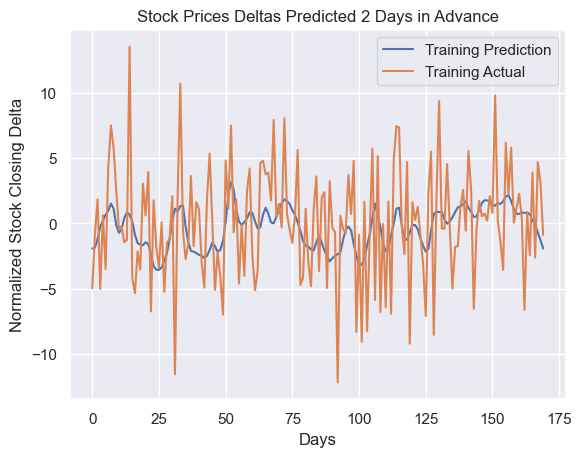

In [69]:
train_predictions = mymodel.predict(datax_train)
train_actual = datay_train
plt.plot(train_predictions[:, 1], label='Training Prediction')
plt.plot(train_actual[:, 1], label='Training Actual')
plt.title('Stock Prices Deltas Predicted 2 Days in Advance')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Closing Delta')
plt.legend()

In [70]:
diff = np.sign(train_predictions[:, 1].flatten())-np.sign(train_actual[:, 1].flatten())
thresh = np.max(np.abs(train_predictions[:, 1]))/2
significant = np.where(np.abs(train_predictions[:, 1].flatten()) > thresh)
print('We perform predictions for ' + str(len(diff)) + ' days')
print('Let a significant day be a day where the absolute value of the predicted closing delta is greater than ' + str(thresh))
print('There are ' + str(len(significant[0])) + ' such events')
print('Of those events, we predict ' + str(np.count_nonzero(diff[significant])) + ' incorrectly')
num_wrong = np.count_nonzero(diff)
err = num_wrong/len(diff)
print('Overall Error Rate: ' + str(err*100) + '%')

We perform predictions for 170 days
Let a significant day be a day where the absolute value of the predicted closing delta is greater than 1.783994
There are 44 such events
Of those events, we predict 15 incorrectly
Overall Error Rate: 38.82352941176471%


The accumulated % deltas clearly perform noticably better than 1-day predictions


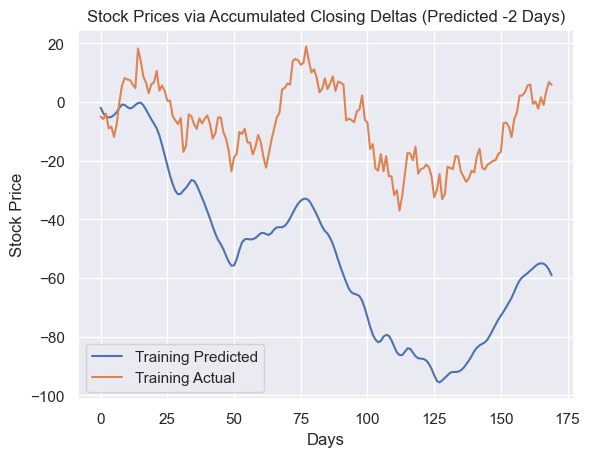

In [71]:
stock_price_train_pred = np.cumsum(train_predictions[:, 1])
stock_price_train_actual = np.cumsum(train_actual[:, 1])
plt.plot(stock_price_train_pred, label='Training Predicted')
plt.plot(stock_price_train_actual, label='Training Actual')
plt.title('Stock Prices via Accumulated Closing Deltas (Predicted -2 Days)')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
print('The accumulated % deltas clearly perform noticably better than 1-day predictions')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


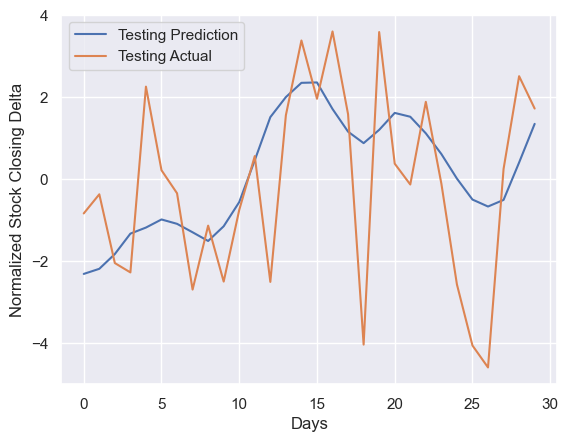

In [72]:
test_predictions = mymodel.predict(datax_test)
test_actual = datay_test
plt.plot(test_predictions[:, 1], label='Testing Prediction')
plt.plot(test_actual[:, 1], label='Testing Actual')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Closing Delta')
plt.legend()